# Creating an Amundsen Sea Low (ASL) index

This work is a continuation of my 2013 and 2016 papers as described [here](https://scotthosking.com/asl_index)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
from skimage.feature import peak_local_max

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Definitions

In [2]:
def asl_sector_mean(da, asl_region, mask):
    a = da.where(mask == 0).sel( latitude=slice(asl_region['north'],asl_region['south']), 
                longitude=slice(asl_region['west'],asl_region['east']) ).mean().values
    return a


def get_lows(da, mask):
    '''
    da for one point in time (with lats x lons)
    '''
    
    lons, lats = da.longitude.values, da.latitude.values
    
    sector_mean_pres = asl_sector_mean(da, asl_region, mask)
    threshold = sector_mean_pres

    time_str = str(da.time.values)[:10]
    
    # fill land in with highest value to limit lows being found here
    da_max   = da.max().values
    da       = da.where(mask == 0).fillna(da_max)
        
    invert_data = (da*-1.).values     # search for peaks rather than minima
    
    if threshold is None:
        threshold_abs = invert_data.mean()
    else:
        threshold_abs  = threshold * -1  # define threshold cut-off for peaks (inverted lows)
                
    minima_yx = peak_local_max(invert_data,            # input data
                           min_distance=5,             # peaks are separated by at least min_distance
                           num_peaks=3,                # maximum number of peaks
                           exclude_border=False,       # excludes peaks from within min_distance pixels of the border
                           threshold_abs=threshold_abs # minimum intensity of peaks
                           )
    
    minima_lat, minima_lon, pressure = [], [], []
    for minima in minima_yx:
        minima_lat.append(lats[minima[0]])
        minima_lon.append(lons[minima[1]])
        pressure.append(da.values[minima[0],minima[1]])
    
    df = pd.DataFrame()
    df['lat']        = minima_lat
    df['lon']        = minima_lon
    df['ActCenPres'] = pressure
    df['SectorPres'] = sector_mean_pres
    df['time']       = time_str
    
    ### Add relative central pressure (Hosking et al. 2013)
    df['RelCenPres'] = df['ActCenPres'] - df['SectorPres']

    ### re-order columns
    df = df[['time','lon','lat','ActCenPres','SectorPres','RelCenPres']]
    
    ### clean-up DataFrame
    df = df.reset_index(drop=True)

    return df


def define_asl(df, region):
    ### select only those points within ASL box
    df2 = df[(df['lon'] > region['west'])  & 
                (df['lon'] < region['east'])  & 
                (df['lat'] > region['south']) & 
                (df['lat'] < region['north']) ]

    ### For each time, get the row with the lowest minima_number
    df2 = df2.loc[df2.groupby('time')['ActCenPres'].idxmin()]
    
    df2 = df2.reset_index(drop=True)

    return df2


def slice_region(da, region, boarder=8):
    da = da.sel( latitude=slice(region['north']+boarder,region['south']-boarder), 
                longitude=slice(region['west']-boarder,region['east']+boarder))
    return da

## Read in data

In [3]:
da   = xr.open_dataset('data/msl_1979.nc').msl
mask = xr.open_dataset('data/invariant.nc').lsm

In [4]:
da

<xarray.DataArray 'msl' (time: 12, latitude: 241, longitude: 480)>
[1388160 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 1979-12-01

In [5]:
mask

<xarray.DataArray 'lsm' (latitude: 241, longitude: 480)>
[115680 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
    time       datetime64[ns] ...
Attributes:
    units:          (0 - 1)
    long_name:      Land-sea mask
    standard_name:  land_binary_mask

## Select region and apply land-sea mask

In [6]:
da_mask = da.where(mask == 0)

# region of interest (asl sector)
asl_region = {'west':170., 'east':298., 'south':-80., 'north':-60.}

### slice area around ASL region
da      = slice_region(da, asl_region)
da_mask = slice_region(da_mask, asl_region)

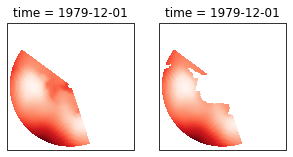

In [7]:
plt.figure(figsize=(5,5))
ax1 = plt.subplot( 121, projection=ccrs.Stereographic(central_longitude=0., central_latitude=-90.) )
ax1.set_extent([-180,180,-90,-50], ccrs.PlateCarree())
da.isel(time=-1).plot.pcolormesh( 'longitude', 'latitude', cmap='Reds', 
                                        transform=ccrs.PlateCarree(), add_colorbar=False )

ax2 = plt.subplot( 122, projection=ccrs.Stereographic(central_longitude=0., central_latitude=-90.) )
ax2.set_extent([-180,180,-90,-50], ccrs.PlateCarree())
da_mask.isel(time=-1).plot.pcolormesh( 'longitude', 'latitude', cmap='Reds', 
                                        transform=ccrs.PlateCarree(), add_colorbar=False )

## Loop through each time and identify lows

In [8]:
# change units
da = da / 100. 
da = da.assign_attrs(units='hPa')

ntime        = da.time.shape[0]
all_lows_dfs = pd.DataFrame()

for t in range(0,ntime):
    da_t         = da.isel(time=t)
    all_lows_df  = get_lows(da_t, mask)
    all_lows_dfs = pd.concat([all_lows_dfs, all_lows_df], ignore_index=True)

asl_df = define_asl(all_lows_dfs, asl_region)

In [12]:
all_lows_dfs

,time,lon,lat,ActCenPres,SectorPres,RelCenPres
0,1979-01-01,219.00,-69.75,982.389038,986.102478,-3.713440
1,1979-01-01,264.75,-69.00,983.148621,986.102478,-2.953857
2,1979-01-01,200.25,-61.50,983.843018,986.102478,-2.259460
3,1979-02-01,196.50,-71.25,973.716003,982.970764,-9.254761
4,1979-02-01,166.50,-66.00,979.914429,982.970764,-3.056335
5,1979-02-01,277.50,-64.50,981.018372,982.970764,-1.952393
6,1979-03-01,225.00,-69.75,972.314209,980.528137,-8.213928
7,1979-04-01,273.75,-68.25,967.716553,979.400818,-11.684265
8,1979-05-01,191.25,-70.50,977.479431,987.183167,-9.703735
9,1979-05-01,200.25,-72.75,977.629089,987.183167,-9.554077


In [9]:
asl_df

,time,lon,lat,ActCenPres,SectorPres,RelCenPres
0,1979-01-01,219.00,-69.75,982.389038,986.102478,-3.713440
1,1979-02-01,196.50,-71.25,973.716003,982.970764,-9.254761
2,1979-03-01,225.00,-69.75,972.314209,980.528137,-8.213928
3,1979-04-01,273.75,-68.25,967.716553,979.400818,-11.684265
4,1979-05-01,191.25,-70.50,977.479431,987.183167,-9.703735
5,1979-06-01,217.50,-70.50,966.913269,977.867493,-10.954224
6,1979-07-01,249.75,-71.25,972.705261,980.146851,-7.441589
7,1979-08-01,258.00,-71.25,972.428589,986.684937,-14.256348
8,1979-09-01,203.25,-74.25,972.788513,982.188477,-9.399963
9,1979-10-01,252.00,-72.00,973.372986,982.318115,-8.945129


In [10]:
asl_df
print(asl_df.shape)
np.save('/g/data/v45/pas561/gdcc21/asl/era5_asl.npy',asl_df)
a=np.load('/g/data/v45/pas561/gdcc21/asl/era5_asl.npy',allow_pickle=True)
print(a.shape)


(12, 6)
(12, 6)


## Plotting: location of minimas in pressure field

In [9]:
def draw_regional_box( region, transform=None ):
    '''
    Draw box around a region on a map
    region is a dictionary with west,east,south,north
    '''

    if transform == None:
        transform = ccrs.PlateCarree()

    plt.plot([region['west'], region['west']], [region['south'],region['north']], 
                 'k-', transform=transform, linewidth=1)
    plt.plot([region['east'], region['east']], [region['south'],region['north']], 
                 'k-', transform=transform, linewidth=1)
    
    for i in range( np.int(region['west']),np.int(region['east']) ): 
        plt.plot([i,i+1], [region['south'],region['south']], 'k-', transform=transform, linewidth=1)
        plt.plot([i,i+1], [region['north'],region['north']], 'k-', transform=transform, linewidth=1)

<ipython-input-9-aa989ae253b3>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range( np.int(region['west']),np.int(region['east']) ):
<ipython-input-9-aa989ae253b3>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
D

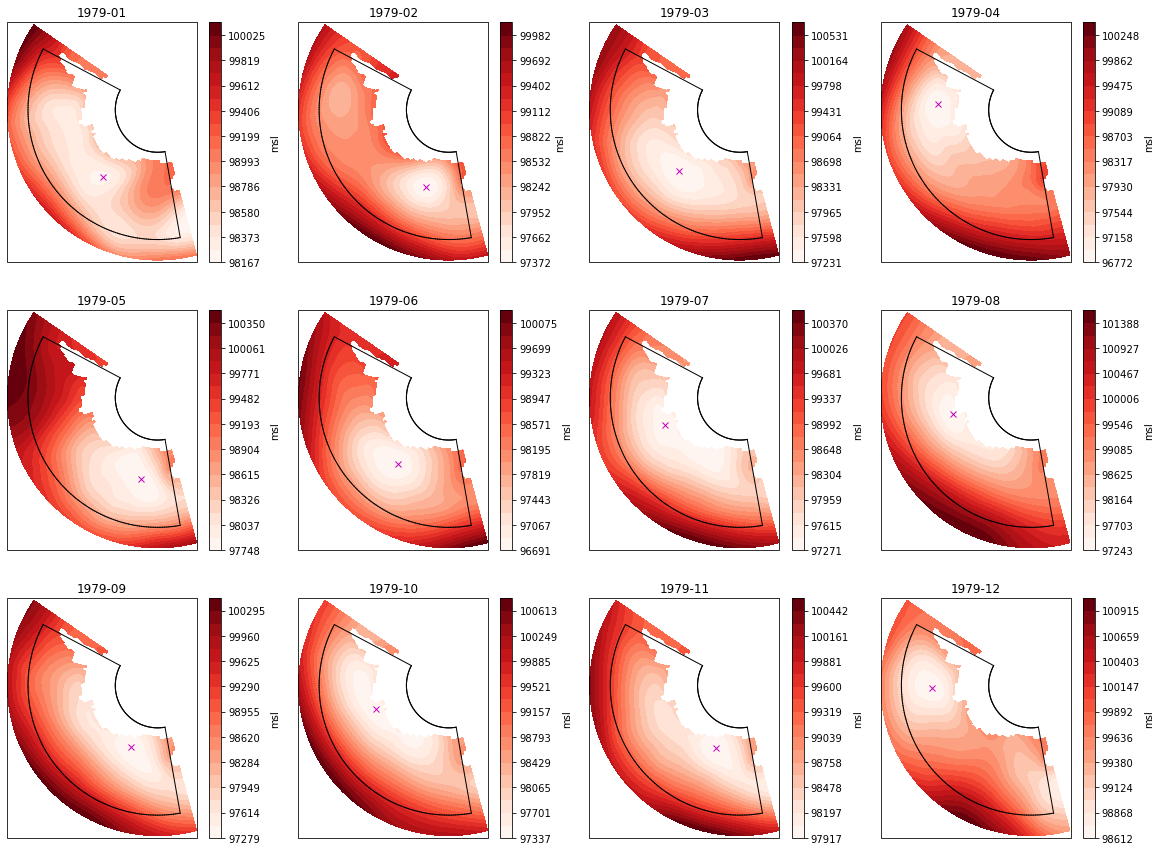

In [11]:
plt.figure(figsize=(20,15))

for i in range(0,12):
    
    da_2D = da_mask.isel(time=i)

    da_2D = da_2D.sel(latitude=slice(-55,-90),longitude=slice(165,305))

    ax = plt.subplot( 3, 4, i+1, 
                        projection=ccrs.Stereographic(central_longitude=0., 
                                                      central_latitude=-90.) )

    ax.set_extent([165,305,-85,-55], ccrs.PlateCarree())

    result = da_2D.plot.contourf( 'longitude', 'latitude', cmap='Reds', 
                                    transform=ccrs.PlateCarree(), 
                                    add_colorbar=True, 
                                    levels=np.linspace(np.nanmin(da_2D.values), np.nanmax(da_2D.values), 20) )

    # ax.coastlines(resolution='110m')
    ax.set_title(str(da_2D.time.values)[0:7])

    ## mark ASL
    df2 = asl_df[ asl_df['time'] == str(da_2D.time.values)[0:10]]
    if len(df2) > 0:
        ax.plot(df2['lon'], df2['lat'], 'mx', transform=ccrs.PlateCarree() )
    draw_regional_box(asl_region)

print('')